***
# <font color=green size=10>Lista 1: geração de números pseudoaleatórios</font>
***

Universidade de Brasília/PPCA
Métodos Computacionais Intensivos para Mineração de Dados

Prof. Guilherme Souza Rodrigues

Aluno: Paulo Célio Soares da Silva Júnior - 22/0005605

▶ Importando bibliotecas.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import string

▶ Definindo constantes globais.

In [2]:
# valor da semente para os geradores de números pseudoaleatórios
SEED = 42

## Questão 1 - Simulando computacionalmente o gerador de Babel.

Todo seu destino, a cura do câncer e até o que vai acontecer no fim do mundo. Todas essas respostas jáestão escritas na Biblioteca de Babel. Essa biblioteca proposta por Jorge Luís Borges é composta por umnúmero infinito de galerias, contendo todos os livros possíveis.

"[. . . ] Um (livro) constava das letras M C V malevolamente repetidas da primeira linha até a última.Outro é um simples labirinto de letras mas a penúltima página diz ‘ó tempo tuas pirâmides’."

A maior parte dos livros não tem qualquer significado. Entretanto, embora improváveis, certos textosresultam em grandes obras, como o Bhagavad Gita. Considerando as afirmações acima e a lista de palavras existentes na língua portuguesa (disponível no arquivo "Dicionario.txt"), responda aos itens a seguir.

▶ Definindo variáveis para a questão.

In [3]:
# cria um dataset do alfabeto contendo a letra, se é vogal e a frequência da letra na língua portuguesa
alfabeto = pd.DataFrame(list(zip(list(string.ascii_lowercase),
                                 [1 if l in "aeiou" else 0 for l in list(string.ascii_lowercase)],
                                 [0.1463, 0.0104, 0.0388, 0.0499, 0.1257, 0.0102, 0.013, 0.0128,
                                  0.0618, 0.004, 0.0002, 0.0278, 0.0474, 0.0505, 0.1073, 0.0252,
                                  0.012, 0.0653, 0.0781, 0.0434, 0.0463, 0.0166,0.0001, 0.0021,
                                  0.0001, 0.0047])),
                        columns=["letra", "vogal", "frequencia"])
# número de sequências de caracteres com 5 letras possíveis dentre as 26 do alfabeto
# amostras ordenadas com reposição - (26^5)
num_seq_caracteres_possiveis = (alfabeto.shape[0] ** 5)

▶ Importando e tratando o dicionário fornecido.

In [4]:
dicionario = pd.read_csv("Dicionario.txt", names=["vocabulo"])
# limpa os espaços em branco antes ou depois das palavras
dicionario.vocabulo = dicionario.vocabulo.str.strip()
# transforma todos os caracteres em minúsculos
dicionario.vocabulo = dicionario.vocabulo.str.lower()
# limpa as entradas duplicadas do dicionário
dicionario.drop_duplicates(inplace=True, ignore_index=True)
# cria um campo no dataset contendo o tamanho da palavra
dicionario["tamanho"] = dicionario.vocabulo.str.len()

▶ Definindo funções auxiliares para resolução da questão.

In [5]:
def gerar_amostra_seq_caracteres_aleatoria(n:int=10**6, tamanho_seq_carateres=5, vogais_consoantes_alternadas=False, p_uniforme=True, random_state:int=None) -> list:
    """
    Função geradora de amostra, de tamanho n, de sequências de caracteres aleatórias.

    :param n: Número de observações da amostra. Padrão = 1.000.000.
    :param tamanho_seq_carateres: Tamanho da sequência de caracteres a ser gerada.
    :param vogais_consoantes_alternadas: Indica se o gerador deve gerar palavras com
        vogais e consoantes alternadas. Padrão = False.
    :param p_uniforme: Indica se a probabilidade da ocorrência dos caracteres sorteados pelo
        gerador deve ser uniforme. Se o valor for False, utiliza as frequências de cada um caracter
        na língua portuguesa. Padrão = True.
    :param random_state: Semente a ser utilizada pelo gerador. Padrão = None.

    :return: Lista com n sequências de caracteres geradas.
    """
    # define a semente a ser usada pelo NumPy
    np.random.seed(random_state)

    letras = alfabeto.letra.to_list()
    amostra = []
    for _ in range(n):
        if not vogais_consoantes_alternadas:
            # gera sequência de carateres com 5 letras aleatoriamente

            p = None
            if not p_uniforme:
                # o parâmetro indica se deve ou não ser usada probabilidade de distribuição uniforme
                # caso não seja uniforme, ajusta a probabilidade de acordo com a frequência do aparecimento
                # de cada uma das letras do alfabeto na língua portuguesa
                p = alfabeto.frequencia.to_list()

            while True:
                sequencia_caracteres = ''.join(np.random.choice(letras,
                                                                size=tamanho_seq_carateres,
                                                                replace=True, p=p))
                if (not p_uniforme and "a" in sequencia_caracteres) or p_uniforme:
                    break

        else:
            # gera sequência de caracteres, alternando-se vogais e consoantes aleatórias

            # inicia variáveis
            vogais = alfabeto.query("vogal == 1").letra.to_list()
            consoantes = alfabeto.query("vogal == 0").letra.to_list()
            letra_corrente_vogal = False

            # gera a primeira letra da sequência de caracteres e registra se é uma vogal
            sequencia_caracteres = np.random.choice(letras)
            if sequencia_caracteres in vogais:
                letra_corrente_vogal = True

            # gera as demais letras da sequência até atingir o tamanho estabelecido no parâmetro
            for _ in range(1, tamanho_seq_carateres):
                if letra_corrente_vogal:
                    sequencia_caracteres += np.random.choice(consoantes)
                else:
                    sequencia_caracteres += np.random.choice(vogais)
                letra_corrente_vogal = not letra_corrente_vogal

        amostra.append(sequencia_caracteres)

    return amostra

In [6]:
def executar_simulacao_monte_carlo(amostra:list, dicionario_lista:list=None) -> pd.DataFrame:
    """
    Função que executa a simulaçao de Monte Carlo para estimar a probabilidade de ocorrência de palavras em uma amostra, dado um dicionário.

    :param amostra: Amostra a ser utilizada na simulação. Contem as sequências de caracteres geradas
        aleatoriamente.
    :param dicionario_lista: Dicionário que será usado para validação de sequências de caracteres contidas
        na amostra.

    :return: DataFrame Pandas contendo as probabilidades obtidas na simulação.
    """
    # listo contendo as palavras válidas encontradas no dicionário a partir da amostra
    palavras_validas_geradas = []
    # número de sequências de caracteres de incremento de cada iteração da simulação
    step = 10000
    # número inicial de sequências de caracteres a ser analisada na simulação
    num_instancias_simulacao = step
    # inicialização do DataFrame Pandas que armazenará as probabilidades encontradas em cada iteração
    probabilidades = pd.DataFrame()

    for idx, sequencia_caracteres in enumerate(amostra):
        if dicionario_lista != None:
            # se for passado dicionário como parâmetro, busca a sequência de caracteres nele
            if sequencia_caracteres in dicionario_lista:
                palavras_validas_geradas.append(sequencia_caracteres)
        else:
            # caso contrário, verifica se sequência de caracteres é um palíndromo
            if sequencia_caracteres == sequencia_caracteres[::-1]:
                palavras_validas_geradas.append(sequencia_caracteres)

        # a cada step adiciona a probabilidade encontrada de acordo com o total
        # acumulado de observações
        if idx + 1 == num_instancias_simulacao:
            num_palavras_validas_geradas = len(palavras_validas_geradas)
            probabilidade_simulacao = num_palavras_validas_geradas / num_instancias_simulacao
            probabilidades = pd.concat([probabilidades,
                                        pd.DataFrame({"num_instancias": [num_instancias_simulacao],
                                                      "num_palavras_validas_geradas": [num_palavras_validas_geradas],
                                                      "probabilidade": [probabilidade_simulacao],
                                                      "palavras_validas_geradas": [str(palavras_validas_geradas)]})],
                                       axis=0, ignore_index=True)
            num_instancias_simulacao += step

    return probabilidades

In [7]:
def plotar_grafico_probabilidades(probabilidades_estimadas:pd.DataFrame, largura:float=12, altura:float=6):
    """
    Função que plota o gráfico de linha com as probabilidades estimadas encontradas na simulação. A linha tracejada horizontal vermelha indica a média das probabilidades estimadas.

    :param probabilidades_estimadas: DataFrame Pandas contendo as probabilidades estimadas registradas em determinada simulação.
    :param largura: Largura do gráfico em polegadas. Padrão = 12.
    :param altura: Altura do gráfico em polegadas. Padrão = 6
    """
    ax = sns.lineplot(data=probabilidades_estimadas, x="num_instancias", y="probabilidade")
    ax.figure.set_size_inches(largura, altura)
    ax.hlines(y=probabilidades_estimadas.probabilidade.mean(), xmin=0, xmax=probabilidades_estimadas.num_instancias.max(), colors='red', linestyles='dashed')
    ax

### a)

___

Estime via simulação computacional (Monte Carlo) a probabilidade de se gerar uma palavra válida (isso é, do dicionário) ao sortear ao acaso sequências de 5 letras (todas com a mesma probabilidade). Em seguida, calcule analiticamente tal probabilidade e faça um gráfico indicando se a estimativa obtida se aproxima do valor teórico conforme a amostra aumenta. **Atenção**: utilize somente as letras do alfabeto sem carateres especiais.


▶ Filtrando, a partir do dicionário fornecido, palavras de 5 letras e criando novo dicionário.

In [8]:
dicionario_5_letras = dicionario.query("tamanho == 5")
dicionario_5_letras.head()

,vocabulo,tamanho
1,aarao,5
11,abaco,5
13,abade,5
19,abafa,5
69,abafe,5


▶ Obtendo e exibindo as probabilidades estimadas e teórica da simulação.

In [9]:
# tenta abrir arquivo csv com probabilidades estimadas previamente calculadas
# caso não encontre um arquivo, gera amostra, executa a simulação e salva o resultado em um arquivo csv
amostra_5_letras = []
try:
    probabilidades_estimadas_5_letras = pd.read_csv("probabilidades_estimadas_5_letras.csv")
except FileNotFoundError:
    amostra_5_letras = gerar_amostra_seq_caracteres_aleatoria(random_state=SEED)
    probabilidades_estimadas_5_letras = executar_simulacao_monte_carlo(amostra_5_letras, dicionario_5_letras.vocabulo.to_list())
    probabilidades_estimadas_5_letras.to_csv("probabilidades_estimadas_5_letras.csv", index=False)

# imprime a probabilidade média encontrada nas simulações
print(f"Probabilidade média estimada das simulações: {probabilidades_estimadas_5_letras.probabilidade.mean() * 100:0.8f}%")

# calcula e imprime a probabilidade teórica
num_palavras_dicionario_5_letras = dicionario_5_letras.shape[0]
probabilidade_teorica_5_letras = num_palavras_dicionario_5_letras / num_seq_caracteres_possiveis
print(f"Probabilidade teórica de uma palavra válida de 5 letras: {probabilidade_teorica_5_letras * 100:0.8f}%")

Probabilidade média estimada das simulações: 0.04665845%
Probabilidade teórica de uma palavra válida de 5 letras: 0.04567653%


▶ Plotando o gráfico das probabilidades da simulação.

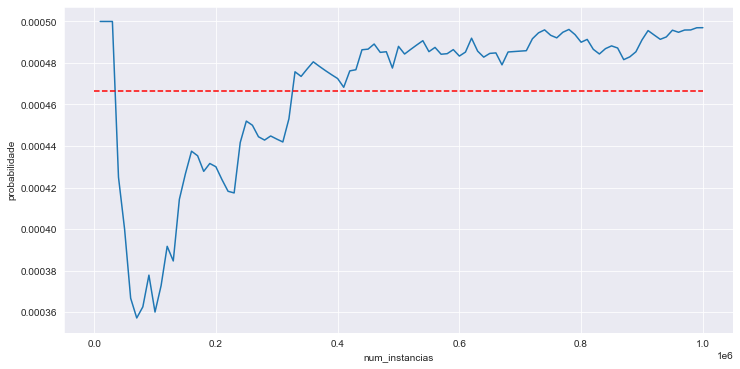

In [10]:
plotar_grafico_probabilidades(probabilidades_estimadas_5_letras)

### b)

___

Estime a probabilidade da sequência gerada ser um palíndromo (ou seja, pode ser lida, indiferentemente,
da esquerda para direita ou da direita para esquerda). Compare o resultado com a probabilidade exata,
calculada analiticamente.

▶ Obtendo e exibindo as probabilidades estimadas e teórica da simulação.

In [11]:
# tenta abrir arquivo csv com probabilidades estimadas previamente calculadas
# caso não encontre um arquivo, gera amostra, executa a simulação e salva o resultado em um arquivo csv
try:
    probabilidades_estimadas_palindromo = pd.read_csv("probabilidades_estimadas_palindromo.csv")
except FileNotFoundError:
    probabilidades_estimadas_palindromo = executar_simulacao_monte_carlo(amostra_5_letras)
    probabilidades_estimadas_palindromo.to_csv("probabilidades_estimadas_palindromo.csv", index=False)

# imprime a probabilidade média encontrada nas simulações
print(f"Probabilidade média estimada das simulações: {probabilidades_estimadas_palindromo.probabilidade.mean() * 100:0.8f}%")

# calcula e imprime a probabilidade teórica
probabilidade_teorica_palindromo = 26 ** 3 / num_seq_caracteres_possiveis
print(f"Probabilidade teórica de um palíndromo de 5 letras: {probabilidade_teorica_palindromo * 100:0.8f}%")

Probabilidade média estimada das simulações: 0.15311073%
Probabilidade teórica de um palíndromo de 5 letras: 0.14792899%


▶ Plotando o gráfico das probabilidades da simulação.

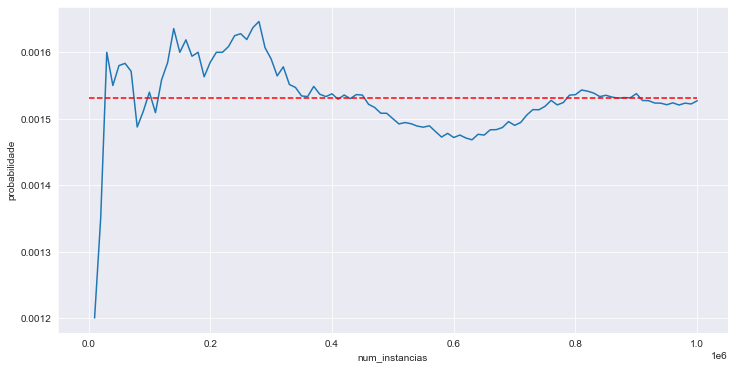

In [12]:
plotar_grafico_probabilidades(probabilidades_estimadas_palindromo)

### c)

___

Construa um gerador que alterne entre consoantes e vogais (se uma letra for uma vogal, a próxima será
uma consoante e vice-versa). Qual a probabilidade de gerar uma palavra válida com este novo gerador?

▶ Obtendo e exibindo as probabilidades estimadas da simulação.

In [13]:
# tenta abrir arquivo csv com probabilidades estimadas previamente calculadas
# caso não encontre um arquivo, gera amostra, executa a simulação e salva o resultado em um arquivo csv
try:
    probabilidades_estimadas_vogais_consoantes_alternadas = pd.read_csv("probabilidades_estimadas_vogais_consoantes_alternadas.csv")
except FileNotFoundError:
    amostra_vogais_consoantes_alternadas = gerar_amostra_seq_caracteres_aleatoria(vogais_consoantes_alternadas=True, random_state=SEED)
    probabilidades_estimadas_vogais_consoantes_alternadas = executar_simulacao_monte_carlo(amostra_vogais_consoantes_alternadas, dicionario_5_letras.vocabulo.to_list())
    probabilidades_estimadas_vogais_consoantes_alternadas.to_csv("probabilidades_estimadas_vogais_consoantes_alternadas.csv", index=False)

# imprime a probabilidade média encontrada nas simulações
print(f"Probabilidade média estimada das simulações: {probabilidades_estimadas_vogais_consoantes_alternadas.probabilidade.mean() * 100:0.8f}%")

Probabilidade média estimada das simulações: 0.70351765%


▶ Plotando o gráfico das probabilidades da simulação.

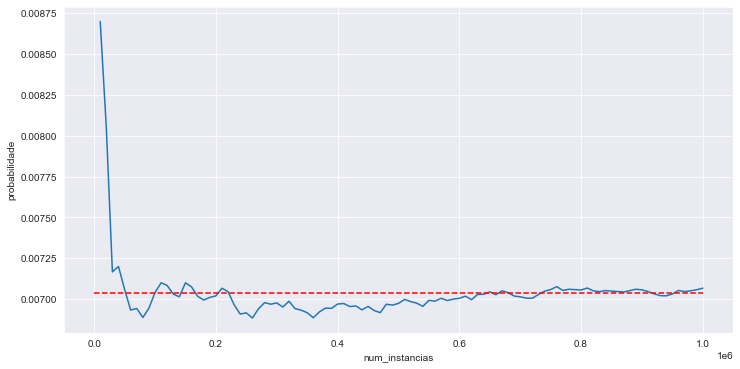

In [14]:
plotar_grafico_probabilidades(probabilidades_estimadas_vogais_consoantes_alternadas)

### d)

___

Considere um processo gerador de sequências de 5 caracteres no qual cada letra é sorteada com probabilidade proporcional à sua respectiva frequência na língua portuguesa (veja essa [página](https://pt.wikipedia.org/wiki/Frequ%C3%AAncia_de_letras)). Suponha que esse processo gerou uma sequência com ao menos um “a”. Neste caso, estime a probabilidade dessa sequência ser uma palavra válida. **Dica**: Use a função $\textsf{sample}$ e edite o parâmetro $\textsf{prob}$. **Para pensar**: Você consegue calcular essa probabilidade analiticamente? (Não precisa responder.)

▶ Obtendo e exibindo as probabilidades estimadas da simulação.

In [15]:
# tenta abrir arquivo csv com probabilidades estimadas previamente calculadas
# caso não encontre um arquivo, gera amostra, executa a simulação e salva o resultado em um arquivo csv
try:
    probabilidades_estimadas_frequencia_5_letras = pd.read_csv("probabilidades_estimadas_frequencia_5_letras.csv")
except FileNotFoundError:
    amostra_frequencia_5_letras = gerar_amostra_seq_caracteres_aleatoria(p_uniforme=False, random_state=SEED)
    probabilidades_estimadas_frequencia_5_letras = executar_simulacao_monte_carlo(amostra_frequencia_5_letras, dicionario_5_letras.vocabulo.to_list())
    probabilidades_estimadas_frequencia_5_letras.to_csv("probabilidades_estimadas_frequencia_5_letras.csv", index=False)

# imprime a probabilidade média encontrada nas simulações
print(f"Probabilidade média estimada das simulações: {probabilidades_estimadas_frequencia_5_letras.probabilidade.mean() * 100:0.8f}%")

Probabilidade média estimada das simulações: 1.01409731%


▶ Plotando o gráfico das probabilidades da simulação.

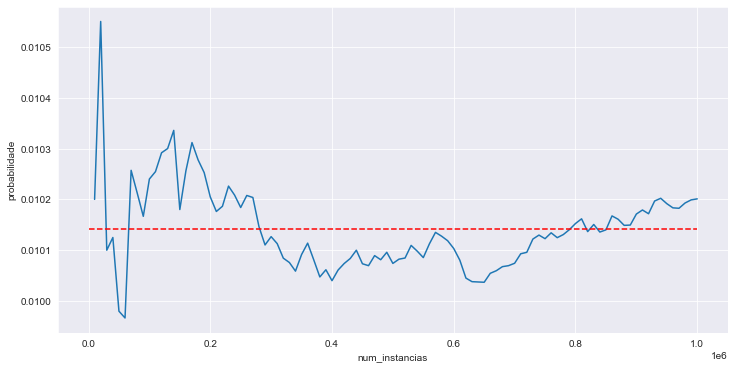

In [16]:
plotar_grafico_probabilidades(probabilidades_estimadas_frequencia_5_letras)

## Questão 2 - Gerando números pseudoaleatórios.


▶ Definindo função auxiliar para resolução da questão.

In [17]:
def plotar_histograma(amostra:list, largura:float=12, altura:float=6, bins:int=50):
    """
    Função que plota histograma com as frequências dos números gerados pelos geradores psedoaleatórios.

    :param amostra: Lista contendo amostra cuja distribuição de frequências será representada no histograma.
    :param largura: Largura do gráfico em polegadas. Padrão = 12.
    :param altura: Altura do gráfico em polegadas. Padrão = 6
    :param bins: Número de tntervalos (idênticos) que representam a frequência de valores. Padrão = 50.
    """
    ax = sns.histplot(amostra, kde=True, bins=bins, stat="density")
    ax.figure.set_size_inches(largura, altura)
    ax

### a)

___

Escreva uma função que gere, a partir do método da transformada inversa, uma amostra aleatória de tamanho $n$ da distribuição Cauchy para $n$ e $\gamma$ arbitrários. A densidade da Cauchy($\gamma$) é dada por
$$f(x) = \frac{1}{\pi\gamma\left[1 + \left(\frac{x}{\gamma}\right)^{2}\right]}.$$
 **Dica:** Veja essa [página](https://en.wikipedia.org/wiki/Cauchy_distribution).

▶ Defininido a função que gera amostras de números pseudoaleatórios.

Para implementação do gerador, que utiliza o método da transformada inversa, utilizou-se a função quantílica da Distribuição Cauchy, dada pela fórmula $Q(p) = \gamma\tan\left[\pi\left(p - \frac{1}{2}\right)\right]$.

In [18]:
def gerar_amostra_aleatoria_cauchy(n:int=10000, gama:float=1, random_state:int=None) -> list:
    """
    Função que implementa um gerador de amostras pseudoaleatórias segundo a distribuição Cauchy, utilizando o método de transformada inversa.

    :param n: Número de observações da amostra. Padrão = 10.000.
    :param gama: Valor do desvio médio absoluto. Padrão = 1.
    :param random_state: Semente a ser utilizada pelo gerador. Padrão = None.

    :return: Lista com a amostra contendo n números gerados pseudoaleatoriamente.
    """
    # define a semente a ser usada pelo NumPy
    np.random.seed(random_state)

    # gera amostra de tamanho n de números uniformes entre 0 e 1
    probabilidades = np.random.uniform(size=n)
    amostra = []

    # para cada número gerado anteriormente, aplica-se a fórmula e adiciona o resultado
    # na lista que será retornada pela função
    for p in probabilidades:
        amostra.append(gama * np.tan(np.pi * (p - 0.5)))

    return amostra

▶ Gerando amostra para exibição no histograma.

In [19]:
amostra_cauchy = gerar_amostra_aleatoria_cauchy(random_state=SEED)

▶ Plotando o histograma da distribuição de frequências da amostra.
Obs.: foram utilizadas apenas as 500 primeiras observações para melhor visualização do gráfico.

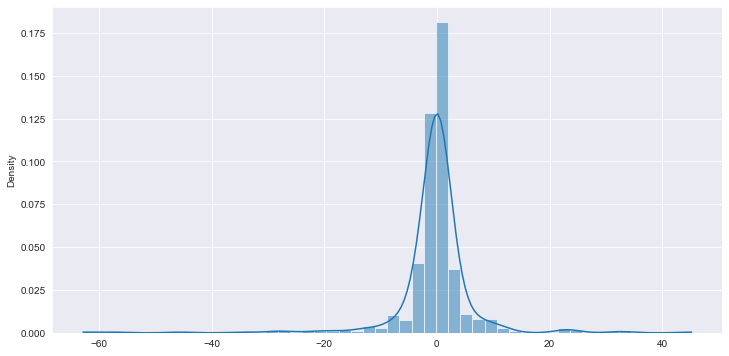

In [20]:
plotar_histograma(amostra_cauchy[0:500])

### b)

___

Uma variável aleatória discreta $X$ tem função massa de probabilidade

\begin{center}
    p(2)  =  0.2\\
    p(3)  =  0.1\\
    p(5)  =  0.2\\
    p(7)  =  0.2\\
    p(9)  =  0.3
\end{center}

Use o método de transformação inversa para gerar uma amostra aleatória de tamanho 1000 a partir dadistribuição de $X$. Construa uma tabela de frequência relativa e compare as probabilidades empíricas com as teóricas. Repita usando a função *sample* do $\textbf{\textsf{R}}$.

▶ Inicializando a tabela de frequência relativa com os parâmetros teóricos definidos.

In [21]:
dados = pd.DataFrame([[2, 0.2], [3, 0.1], [5, 0.2], [7, 0.2], [9, 0.3]], columns=["numero", "probabilidade"])
dados["probabilidade_acumulada"] = dados.probabilidade.cumsum()
dados

,numero,probabilidade,probabilidade_acumulada
0,2,0.2,0.2
1,3,0.1,0.3
2,5,0.2,0.5
3,7,0.2,0.7
4,9,0.3,1.0


▶ Defininido a função que gera amostras de números pseudoaleatórios pelo método de transformada inversa.

In [22]:
def gerar_amostra_aleatoria_x(n:int=10000, random_state:int=None) -> list:
    """
    Função que implementa um gerador de amostras pseudoaleatórias de uma distribuição desconhecida, utilizando o método de transformada inversa a partir das probabilidades conhecidas da distribuição.

    :param n: Número de observações da amostra. Padrão = 10.000.
    :param random_state: Semente a ser utilizada pelo gerador. Padrão = None.

    :return: Lista com a amostra contendo n números gerados pseudoaleatoriamente.
    """
    # define a semente a ser usada pelo NumPy
    np.random.seed(random_state)

    # gera amostra de tamanho n de números uniformes entre 0 e 1
    probabilidades = np.random.uniform(size=n)
    amostra = []

    # para cada número gerado anteriormente, compara-se o valor com a probabilidade acumulada
    # e adiciona o valor imediatamente superior correspondente na lista que será retornada pelo método
    for p in probabilidades:
        amostra.append(dados.query(f"probabilidade_acumulada >= {p}").numero.min())

    return amostra

▶ Gerando amostra para comparação das probabilidades empírica e teórica na tabela de frequência relativa.

In [23]:
amostra_distribuicao_x = gerar_amostra_aleatoria_x(random_state=SEED)
probabilidades_amostra_gerador = pd.Series(amostra_distribuicao_x, name="frequencia_amostra_gerador").value_counts(normalize=True).sort_index()

tabela_freq_relativa = dados.filter(["numero", "probabilidade"])
tabela_freq_relativa = tabela_freq_relativa.join(probabilidades_amostra_gerador, on="numero")
tabela_freq_relativa

,numero,probabilidade,frequencia_amostra_gerador
0,2,0.2,0.2043
1,3,0.1,0.1010
2,5,0.2,0.2023
3,7,0.2,0.2037
4,9,0.3,0.2887


▶ Gerando amostra com o gerador da biblioteca NumPy para comparação das probabilidades empírica e teórica na tabela de frequência relativa.

In [24]:
np.random.seed(SEED)
amostra_numpy = np.random.choice(dados.numero, size=10000, replace=True, p=dados.probabilidade)
probabilidades_amostra_numpy = pd.Series(amostra_numpy, name="frequencia_amostra_numpy").value_counts(normalize=True).sort_index()

tabela_freq_relativa = tabela_freq_relativa.join(probabilidades_amostra_numpy, on="numero")
tabela_freq_relativa

,numero,probabilidade,frequencia_amostra_gerador,frequencia_amostra_numpy
0,2,0.2,0.2043,0.2043
1,3,0.1,0.1010,0.1010
2,5,0.2,0.2023,0.2023
3,7,0.2,0.2037,0.2037
4,9,0.3,0.2887,0.2887


▶ Plotando o histograma da distribuição de frequências da amostra.

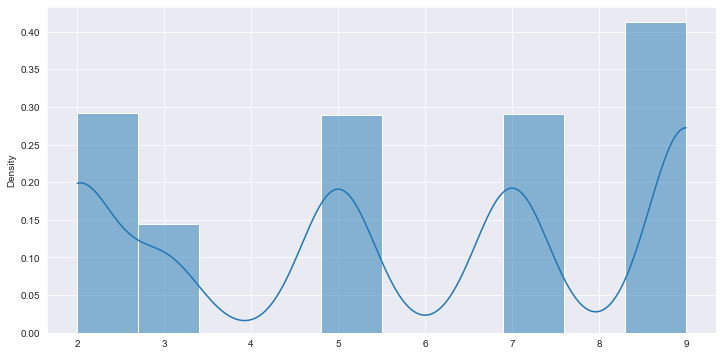

In [25]:
plotar_histograma(amostra_distribuicao_x, bins=10)

### c)

___

Escreva uma função que gere amostras da distribuição Normal padrão $(\mu = 0, \sigma = 1)$ usando o método
de aceitação e rejeição adotando como função geradora de candidatos, $g(x)$, a distribuição Cauchy padrão
$($isso é, com $\gamma =$ 1$)$.

▶ Defininido as implementações das funções densidade de probabilidade a serem utilizadas para geração dos números pseudoaleatórios.

A função densidade de probabilidade de uma distribuição Normal é dada pela fórmula $f(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}}$.

Já a função densidade de probabilidade de uma distribuição Cauchy é dada pela fórmula $f(x) = \frac{1}{\pi\gamma\left[1 + \left(\frac{x}{\gamma}\right)^{2}\right]}$.

In [26]:
def normal_pdf(x:float, mu:float=0, sigma:float=1) -> float:
    """
    Função densidade de probabilidade da distribuição Normal.

    :param x: Valor da variável aleatória contínua.
    :param mu: Valor da média. Padrão = 0.
    :param sigma: Valor do desvio padrão. Padrão = 1.

    :return: Probabilidade da variável aleatória.
    """
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def cauchy_pdf(x:float, gama:float=1) -> float:
    """
    Função Densidade de Probabilidade da Distribuição Cauchy.

    :param x: Valor da variável aleatória contínua.
    :param gama: Valor do desvio médio absoluto. Padrão = 1.

    :return: Probabilidade da variável aleatória.
    """
    return 1 / (np.pi * gama * (1 + (x / gama) ** 2))

▶ Defininido a função que gera amostras de números pseudoaleatórios pelo método de aceitação e rejeição.

In [27]:
def gerar_amostra_aleatoria_normal(n:int=10000) -> list:
    """
    Função que implementa um gerador de amostras pseudoaleatórias segundo a distribuição normal, utilizando o método de aceitação e rejeição.

    :param n: Número de observações da amostra. Padrão = 10.000.

    :return: Lista com amostra contendo n números gerados pseudoaleatoriamente.
    """
    # definindo a constante entre as funções densidade de probabilidade das duas distribuições
    c = normal_pdf(1) / cauchy_pdf(1)

    amostra = []
    i = 0
    while i < n:
        # gera uma variável aleatória representada pela distribuição Cauchy
        y = gerar_amostra_aleatoria_cauchy(1)[0]

        # gera um número uniformes entre 0 e 1
        u = np.random.uniform()

        # caso o número uniforme seja menor que a razão f(x) / c * g(x), aceita o valor,
        # adicionando-o na lista que será retornada pela função
        if u < (normal_pdf(y) / (c * cauchy_pdf(y))):
            amostra.append(y)
            i = i + 1

    return amostra

▶ Gerando amostra para exibição no histograma.

In [28]:
amostra_normal = gerar_amostra_aleatoria_normal()
amostra_normal[:5]

[1.0397516075548476,
 -0.3364429911784686,
 -0.7701590928120616,
 -1.0365842825068108,
 1.2296797021853119]

▶ Exibindo a média e o desvio padrão da amostra gerada segundo a distribuição normal.

In [29]:
print("Média:", np.mean(amostra_normal))
print("Desvio Padrão:", np.std(amostra_normal))

Média: -0.002851360490852561
Desvio Padrão: 0.9971873596025149


▶ Plotando o histograma da distribuição de frequências da amostra.

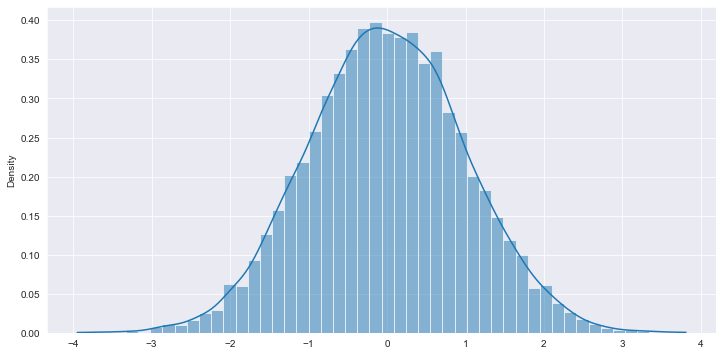

In [30]:
plotar_histograma(amostra_normal)